# 네이버 영화 리뷰 감성 분석

## 1. 데이터 준비와 확인

In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7fee0eb049d0>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

     |████████████████████████████████| 19.4 MB 10.8 MB/s 
     |████████████████████████████████| 448 kB 49.5 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 25.51 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-18 03:11:17--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
L

## 2. 데이터로더 구성

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = mecab.morphs(sentence)
        curr_data = [word for word in curr_data if not word in stopwords]
        result.append(curr_data)
    return result

In [ ]:
def load_data(train_data, test_data, num_words=10000):
    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거
    x_train = tokenize_and_remove_stopwords(train_data['document'],stopwords, mecab)
    x_test = tokenize_and_remove_stopwords(test_data['document'],stopwords, mecab)

    # 단어장 만드는 중
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>','<BOS>','<UNK>','<UNUSED>'] + [key for key,_ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

In [ ]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
print(x_train[10])

[2, 4, 39, 229, 6, 535]


In [ ]:
index_to_word = {index:word for word,index in word_to_index.items()}

In [ ]:
print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '<UNUSED>', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것을 말한다.

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 무장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return " ".join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentenses, index_to_word):
    return [get_decoded_sentence(encoded_sentense, index_to_word) for encoded_sentense in encoded_sentenses]

In [ ]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

## 3. 모델 구성을 위한 데이터 분석 및 가공

In [ ]:
# 데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print("문장길이 평균 :", np.mean(num_tokens))
print("문장길이 최대 :", np.max(num_tokens))
print("문장길이 표준편차 :", np.std(num_tokens))

# 예를 들면 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)

maxlen = int(max_tokens)
print("pad_sequence maxlen :", maxlen)
print("전체 문장의 {:.2}%가 maxlen 설정값 이내에 포함됩니다.".format(np.sum(num_tokens < max_tokens)/len(num_tokens)))


문장길이 평균 : 15.96938143432699
문장길이 최대 : 116
문장길이 표준편차 : 12.843571939469296
pad_sequence maxlen : 41
전체 문장의 0.93%가 maxlen 설정값 이내에 포함됩니다.


In [ ]:
# 패딩 추가
x_train = pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
x_test = pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


## 4. 모델 구성 및 validation 구성

In [ ]:
vocab_size = 10000
word_vector_dim = 200 # 보통 2의 배수로 지정

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


## 모델훈련

In [ ]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [ ]:
model.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 50
hist = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=32, validation_data=(x_val, y_val))
model.save('my_model.h5')

In [ ]:
result = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 8s - loss: 1.1225 - accuracy: 0.8198 - 8s/epoch - 5ms/step


In [ ]:
print(result)

[1.1225112676620483, 0.8197611570358276]


## 6. loss, accuracy 그래프 시각화

In [ ]:
history_dict = hist.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

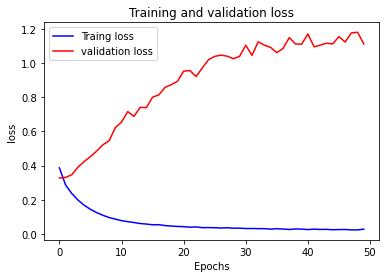

In [ ]:
plt.plot(loss,c='b',label='Traing loss')
plt.plot(val_loss,c='r',label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

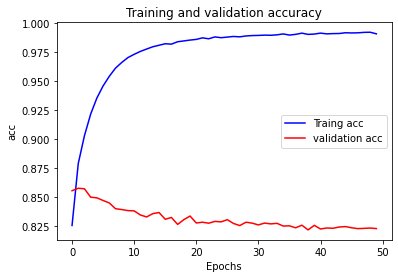

In [ ]:
plt.plot(acc,c='b',label='Traing acc')
plt.plot(val_acc,c='r',label='validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

# Proj: 네이버 영화 리뷰 감성 분류에 SentencePiece적용하기

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [ ]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2022-05-18 04:18:46--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-05-18 04:18:46--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [ ]:
!tar -xzvf korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko
